In [2]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

# Téma 4: Operátor $B$, ARIMA(p,d,q)

# Operátor zpoždění

Operátor zpoždění ([lag operator, backshift operator](https://en.wikipedia.org/wiki/Lag_operator)) značíme $B$ nebo $L$ a používáme pro zjednodušení zápisu:

$$
\begin{aligned}
BX_t &= X_{t-1} \\
B^{-1}X_t &= X_{t+1} \\
B^k X_t &= \underbrace{B\cdot B \cdots B}_{k\times}X_t = X_{t-k}.
\end{aligned}
$$

Díky tomu můžeme zavádět **AR(p)** proces takto:

$$
\begin{aligned}
X_t &= \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t \qquad\text{(vyjádříme $\varepsilon_t$)}\\
\varepsilon_t &= X_t - \phi_1 B^1 X_{t} - \ldots - \phi_p B^p X_{t}
= \left( 1 - \sum_{i=1}^p \phi_i B^i\right) X_t.
\end{aligned}
$$

Analogicky pro **MA(q)** máme

$$
X_t = \left( 1 + \sum_{i=1}^q \theta_i B^i \right) \varepsilon_t.
$$

Analogickými úpravami bychom pro **ARMA(p,q)** bez konstanty $c$ dostali

$$
\Phi X_t = \Theta \varepsilon_t, \qquad\text{kde}\qquad
\Phi=1-\sum_{i=1}^p \phi_i B^i \qquad\text{a}\qquad
\Theta = 1+\sum_{i=1}^q \theta_i B^i.
$$

### Operátor diference $\nabla$

$$
\begin{aligned}
\nabla X_t &= X_t - X_{t-1} = (1-B) X_t, \\
\nabla^2 X_t &= \nabla(\nabla X_t) = \nabla X_t - \nabla X_{t-1} = (1-B) \nabla X_t \\
&= (1-B)^2 X_t,\\
\nabla^k X_t &= (1-B)^k X_t.
\end{aligned}
$$

Díky všem uvedeným operátorům můžeme definovat **ARIMA(p,d,q)** model následovně:

$$
{\Phi}(1-B)^d X_t = \Theta \varepsilon_t, \qquad\text{kde}\qquad
\Phi=1-\sum_{i=1}^p \phi_i B^i \qquad\text{a}\qquad
\Theta = 1+\sum_{i=1}^q \theta_i B^i,
$$

popřípadě s konstantou $c$

$$
\Phi (1-B)^d X_t = c + \Theta \varepsilon_t.
$$

**Zkuste si zapsat např. ARIMA(1,1,1), ujasní se vám to :-)**

### K čemu jsou operátory dobré?

- umožňují snadný zápis charakteristických polynomů při vyšetřování stacionarity AR a invertibility MA procesu.
- jde s nimi dělat různá algebraická kouzla díky komutativitě $B(\beta X_t) = \beta BX_t$, distributivitě atd.

# ARMA úvodníček...

Ještě než skočíme do dalšího tématu, podívejme se na záludnosti ARMA modelů. Simulujme několikrát časovou řadu pomocí [arma_generate_sample](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html?highlight=generate#statsmodels.tsa.arima_process.arma_generate_sample) ze statsmodels a zkusme odhadovat řád modelu z nagenerovaných dat. Zjistíme, že ono to s těmi modely a řády není tak jednoduché...

{'bic':              0            1            2
 0  1819.539635  1469.046938  1378.805070
 1  1493.449302  1382.948423  1376.356789
 2  1371.884475  1370.358421  1376.503290
 3  1371.186621  1376.499010  1382.498653,
 'bic_min_order': (2, 1)}

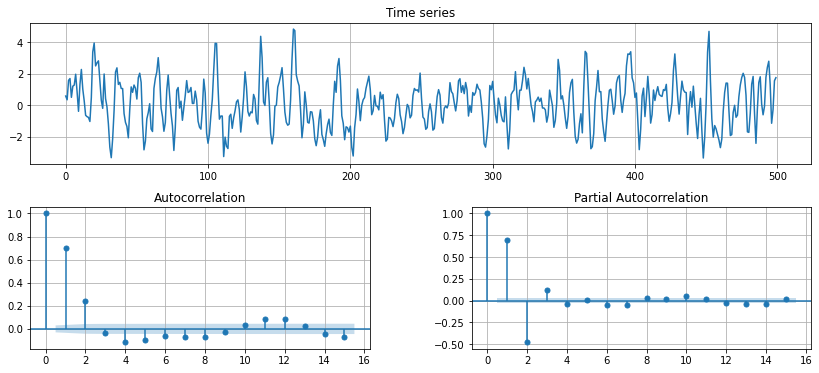

In [3]:
ar_params = [.27]      ### koeficienty AR, bez offsetu
ma_params = [.8, .3]   ### koeficienty MA, bez offsetu
ar = np.r_[1, -np.array(ar_params)]
ma = np.r_[1, np.array(ma_params)]
y = sm.tsa.arma_generate_sample(ar, ma, 500)
tsplot(y)
sm.tsa.arma_order_select_ic(y, ic='bic', max_ar=3, max_ma=2)

# Modely ARIMA(p,d,q)

Nyní se podíváme blíže na modely ARIMA (AutoRegressive Integrated Moving Average). Zde máme hned tři parametry:

- p - řád autoregresní části (AR)
- q - řád modelu klouzavých průměrů (MA)
- d - řád differencování

Diferencováním řady se snažíme odstranit z ní trend nebo náhodnou procházku. Připomeňme, že např. **gaussovská náhodná procházka** má tvar

$$
\begin{aligned}
Y_0 &=0, \\ 
Y_t &= Y_{t-1} + \varepsilon_t, \qquad \text{iid. } \varepsilon_t \sim \mathcal{N}(0, \sigma^2).
\end{aligned}
$$

Diferencování je proces, kdy počítáme veličiny

$$
Y_t' = Y_{t} - Y_{t-1},
$$

což v případě gaussovské náhodné procházky vede na $Y_t' = \varepsilon_t$. Výsledkem diferencováním náhodné procházky je tedy gaussovský bílý šum. Diferencováním reálných dat samozřejmě dostaneme většinou něco jiného, ale zpravidla aspoň přibližně zbaveného trendu.


Podívejme se na gaussovskou náhodnou procházku v simulacích. Zkusme $i,d\in\{0,1,2\}$, co uvidíme v grafu zde a níže.

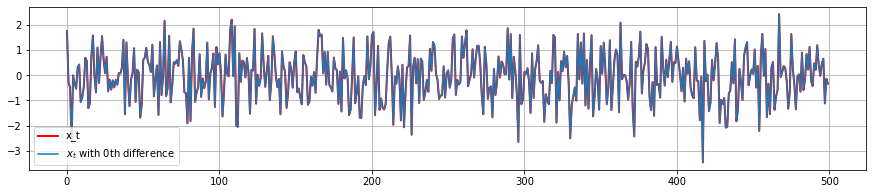

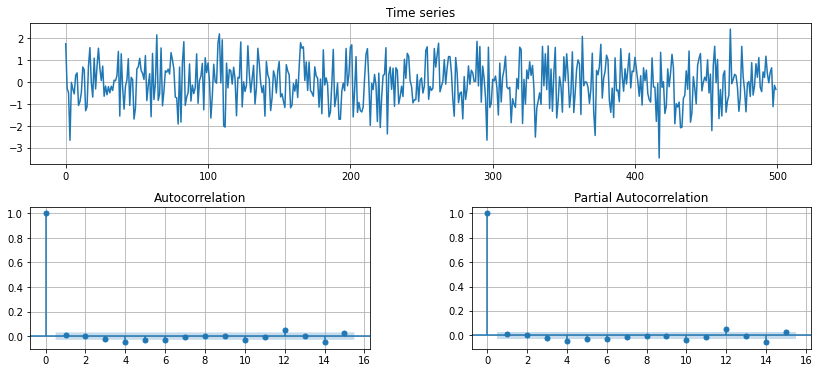

In [8]:
ndat = 500
i = 0                ### řád integrování: 0 = bílý šum, 1 = procházka, 2 = :)
d = 0                ### řád diferencování - d=i -> bílý šum

np.random.seed(11)
x = np.random.normal(size=ndat)
for _ in range(i):
    x = np.cumsum(x)
df = pd.DataFrame({'x': x})
df_diff = df.copy()
for _ in range(d):
    df_diff['x'] = df_diff['x'].diff()
plt.figure(figsize=(15,3))
plt.plot(df['x'], 'r', lw=2, label='x_t')
plt.plot(df_diff['x'], label=rf'$x_t$ with {d}th difference')
plt.legend()
plt.show()
tsplot(df_diff['x'].dropna())

Zkusme se podívat na syrová data `x` a na diferencovaná:

> **Zjištění:**
> - **Časové řady s trendem nebo náhodnou procházkou jsou vždy silně pozitivně autokorelované. V ACF vidíme veliké korelace, v PACF typicky v 1. lagu a blízkou 1.**
> - **Časové řady s ACF v 1. lagu s hodnotami -0.5 a méně mohou být přediferencované.**
> - **Modely s d=1 typicky předpokládají konstantní průměrný trend (náhodná procházka s driftem)..**

To, co vypadá jako význačná charakteristika pro AR proces je ve skutečnosti znamení poddiferencovanosti - diferencováním ji odstraníme a v uvedeném příkladu se dostaneme k ryze náhodnému procesu - procházce. Přediferencováním dostaneme opak - MA charakteristiku. Z toho plyne následující: **AR charakteristika může značit poddiferencovanost časové řady, zatímco MA charakteristika přediferencovanost.** Jedno z užitečných pravidel je, že $d\leq 2$, přičemž druhé diference jsou v praxi relativně řídké. **A při $d=2$ nepoužíváme v ARIMA modelu konstantu $c$.** Výjimky jsou řídké.

> **Role konstanty v ARIMA modelu:**
> - při $d=0$ konstanta zavádí nenulovou střední hodnotu a vyplatí se ji zkusit.
> - při $d=1$ konstanta zavádí nenulový "průměrný" trend a může se vyplatit.
> - při $d=2$ by konstanta měla význam "trendu v trendu", což obvykle nechceme.

## Běžné ARIMA modely

- ARIMA(0,0,0)+c - konstantní model
- ARIMA(0,1,0) - model náhodné procházky (viz výše)
- ARIMA(0,1,0)+c - náhodná procházka s driftem
- ARIMA(1,0,0)+c - AR(1) model
- ARIMA(2,0,0)+c - AR(2) model
- ARIMA(1,1,0)+c - AR(1) model na jednou diferencovaných datech
- ARIMA(2,1,0)+c - AR(2) model na jednou diferencovaných datech
- ARIMA(0,1,1) - jednoduché exponenciální vyhlazování - MA(1) model na diferencovaných datech
- ARIMA(0,1,1)+c - jednoduché exponenciální vyhlazování - MA(1) na diferencovaných datech - s konst. lin. trendem
- ARIMA(1,1,2) - lineární exponenciální vyhlazování s tlumeným trendem
- ARIMA(0,2,2) - zobecněné lineární exponenciální vyhlazování

Zkuste sami identifikovat chování ARIMA(1,0,0)+c kde $c$ je drift (to je nápověda) s parametry:

1. $\phi_1 = 0$
2. $\phi_1 = 1, c=0$
3. $\phi_1 = 1, c \ne 0$
4. $\phi_1 < 0$

(odpovědi: bílý šum, náhodná procházka, náhodná procházka s driftem, řada oscilující mezi kladnými a zápornými hodnotami).

## Obecná pravidla (se spoustou výjimek :))

- $d \leq 2$ - spíše zřídka potřebujeme druhé diference a třetí už jsou vyloženě výjimečné. 
- $d = 2 \Rightarrow$ nepoužíváme skoro nikdy konstantu $c$ v modelu.
- zpravidla volíme $p=0$ nebo $q=0$. Smíšené modely jsou spíše v menšině, ale ve fyzikálních systémech jsou často ARIMA(p,0,p-1).
- $p+q \leq 3$ - složitější modely jsou řídké.
- koeficienty $\phi_i$ blízké $\theta_i$ mohou pracovat proti sobě.
- obecně volíme co nejjednodušší modely.
- modely můžeme porovnat kritérii AIC, BIC.

![arima](img/ARIMA.png)

**ALE:**
- mohou se vyskytnout (a vyskytují) složitější modely porušující výše uvedená pravidla.
- i tak ale $p, q$ by měly být relativně malé (**R**: `auto.arima()` končí u (5,5) z dobrého důvodu)
- **StatsModels**: `tsa.arma_order_select_ic()`
- velkým problémem složitých modelů je totiž **redundance parametrů**.

## Redundance parametrů

AR a MA části modelu pracují i proti sobě - zvýšíme-li řády u obou, mohou se navzájem vyrušit. To je **neužitečné**, neboť roste složitost modelu. Uveďme si jednoduchý příklad. Uvažujme jednoduchý model ARMA(1,2) ve tvaru

$$
X_t = \phi X_{t-1} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2}.
$$

Zřejmě platí, že minulá hodnota

$$
X_{t-1} = \phi X_{t-2} + \varepsilon_{t-1} + \theta_1\varepsilon_{t-2} + \theta_2\varepsilon_{t-3}.
$$

Vynásobme výraz pro $X_{t-1}$ libovolnou nenulovou konstantou $c$,

$$
cX_{t-1} = c\phi X_{t-2} + c\varepsilon_{t-1} + c\theta_1\varepsilon_{t-2} + c\theta_2\varepsilon_{t-3}
$$

a odečtěme od původního výrazu pro $X_t$ nahoře. Po úpravě dostaneme

$$
X_t = (\phi+c) X_{t-1} -c\phi X_{t-2} + \varepsilon_t + (\theta_1-c)\varepsilon_{t-1} + (\theta_2 -c\theta_1)\varepsilon_{t-2} - c\theta_2\varepsilon_{t-3},
$$

což je ARMA(2,3)! A zjevně nejsou parametry jednoznačně určené, neboť $c$ je libovolné. V "backshift" notaci uvedené níže to znamená, že je-li $\phi B X_t = \theta B \varepsilon_t$ odpovídající model procesu, potom je jím i $(1-cB)\phi B X_t = (1-cB) \theta B \varepsilon_t$ pro libovolnou konstantu $c$. Jednoznačnou parametrizaci dostaneme pokrácením všech společných faktorů v AR a MA charakteristických rovnicích - to už jsme ale za hranicí MI-SCR.

### Příklad redundance

Uvažujme bílý šum pro všechna $t$, tj. pro dva konsekutivní libovolné časové okamžiky

$$
\begin{aligned}
X_t &= \varepsilon_t \\
X_{t-1} &= \varepsilon_{t-1}.
\end{aligned}
$$

Vynásobme druhou rovnici např. 0.5 a převeďme vše na jednu stranu

$$
0 = -0.5 X_{t-1} + 0.5 \varepsilon_{t-1}
$$

a jelikož jde o nulu (aspoň ve střední hodnotě), sečtěme to s první rovnicí:

$$
X_t = -0.5 X_{t-1} + \varepsilon_t + 0.5 \varepsilon_{t-1}.
$$

Vidíme, že bílý šum je ekvivalentní k nějakému ARMA(1,1). Přesto, pokud bychom se podívali na ACF a PACF, nic by nenasvědčovalo tomu, že by mělo jít o takto složitější model. Pokud bychom si vynutili fitování ARMA(1,1), potom budou odhady koeficientů symetrické a budou pusobit proti sobě (viz ono $c$ v teorii výše). Toto je jeden z důvodů, proč tolik preferujeme jednodušší modely a proč je vždy rozumné zkoumat grafy ACF a PACF. Podívejme se na příklad:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1432.676
Date:                Tue, 11 Oct 2022   AIC                           2871.352
Time:                        17:41:20   BIC                           2886.075
Sample:                             0   HQIC                          2876.948
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1347      0.974      0.138      0.890      -1.774       2.043
ma.L1         -0.1662      0.968     -0.172      0.864      -2.064       1.732
sigma2         1.0278      0.046     22.585      0.0

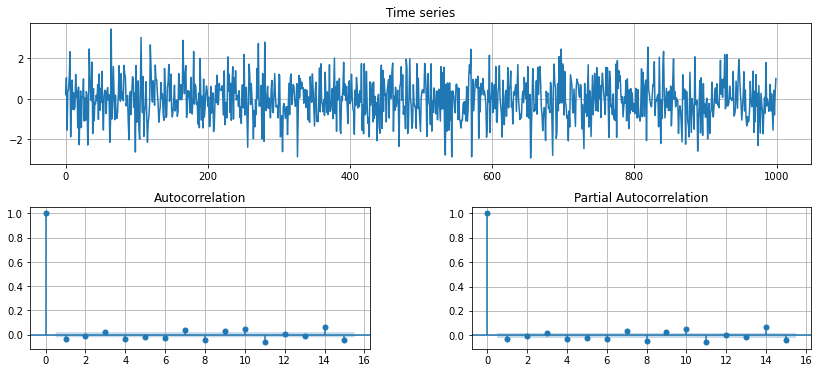

In [19]:
ndat = 1000
x = norm.rvs(size=ndat)
tsplot(x)
model = sm.tsa.arima.ARIMA(x, order=(1,0,1), trend='n').fit()
print(model.summary())

---
---

# Testy a analýzy
**Zaznělo na minulém cvičení, necháme zde pro úplnost :)**

## Nejprve ty analýzy

Jednou z prvních věcí, kterou bychom měli kontrolovat, jsou údaje v tabulce vytištěné metodou `summary()`. Než si ji rozebereme, pojďme se ale podívat ještě na jeden diagnostický obrázek z metody `plot_diagnostics()`. Ukáže nám:
- vývoj standardizovaných rezidui, tj. chyb predikce po odečtení průměru a vydělení směrodatnou odchylkou. Neradi bychom viděli trend nebo nějaké "vzory";
- histogram standardizovaných reziduí spolu s jádrovým (KDE) odhadem a hustotou $\mathcal{N}(0,1)$, které bychom se rádi co nejvíce přiblížili;
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) zobrazující podobu kvantilů rozdělení $\mathcal{N}(0,1)$ a našich reziduí. Ideálem je, aby body ležely na úhlopříčce;
- Korelogram - už známou ACF reziduí.

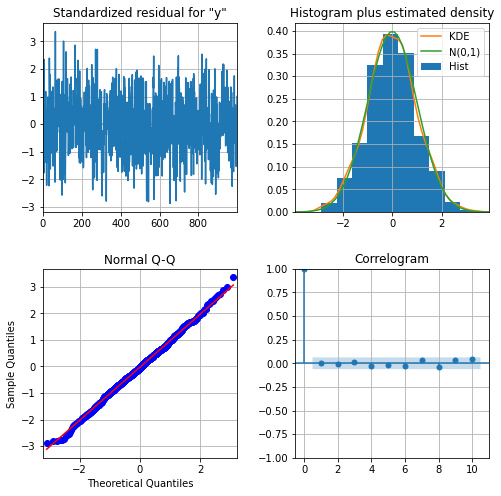

In [20]:
model.plot_diagnostics(figsize=(8,8))
plt.show()

Zajímat by nás dále mohly různé metriky, jako střední kvadratická chyba predikce ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) a střední absolutní chyba predikce ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)). Označíme-li $y_t$ skutečnou pozorovanou hodnotu veličiny v čase $t$ na horizontu $T$, $\hat{y}_t$ její modelem predikovanou hodnotu a reziduum $\tilde\varepsilon_t = \hat{y}_t - y_t$, potom

$$
\operatorname{MSE} = \frac{1}{T} \sum_{t=1}^t \tilde\varepsilon_t^2, \qquad \operatorname{MAE} = \frac{1}{T} \sum_{t=1}^T |\tilde\varepsilon_t|.
$$

Ve `statsmodels` na to máme vlastnosti `mae` a `mse`. Pro úplnost doplňme, že rezidua jsou ve vlastnosti `resid` a že `sse` obsahuje "sum of squared errors", tedy sumu kvadrátů reziduí:

In [21]:
print(f'MSE = {model.mse:.4f} = {model.sse/model.resid.size:.4f} = {np.mean(model.resid**2):.4f}')

MSE = 1.0279 = 1.0279 = 1.0279


In [22]:
# MAE už bez frajeřinek ;)
print(f'MAE = {model.mae:.4f}')

MAE = 0.8047


Zajímat by nás měly samozřejmě rovněž kořeny charakteristických polynomů, abychom se ubezpečili, zda jsou procesy stacionární a/nebo invertibilní:

In [23]:
print(f'AR kořeny: {model.arroots}\nNásobnost: {model.arfreq}')

AR kořeny: [7.42392655]
Násobnost: [0.]


In [24]:
print(f'MA kořeny: {model.maroots}\nNásobnost: {model.mafreq}')

MA kořeny: [6.01665602]
Násobnost: [0.]


Na věrohodnost - *likelihood* - se podíváme příště :)

## Testy...

Připomeňme si letem světem základní princip testování hypotéz. Zavádíme:
- **nulovou hypotézu** $H_0$ - základní hypotéza, její platnost chceme v ideálním případě zamítnout (*reject*).
- **alternativní hypotézu** $H_1$ či $H_A$ - zamítáme-li $H_0$, pak ve prospěch této hypotézy.

V případě analýzy časových řad jsou testy zpravidla **oboustranné**, kde $H_0$ říká, že hodnota testovaného parametru je rovna nějakému číslu, proti $H_1$ která předpokládá nerovnost. Připomeňme, že jednostranné testy by tvrdily, že hodnota parametru je buď větší (pravostranný test), nebo menší (test levostranný).

Jsou dva možné výsledky statistického testu:
- **zamítáme $H_0$** (ve prospěch hyp. alternativní) - tj. máme dostatek statistických důkazů (evidence) v její neprospěch. Anglicky: *reject H_0*.
- **nezamítáme $H_0$** - nemáme dostatek statistických důkazů proti její platnosti. Tím ale $H_0$ nepotvrzujeme!!! Anglicky: *fail to reject $H_0$*.

Testování provádíme na hladině testu (též významnosti) $\alpha\in[0,1]$, zpravidla 0.05 či nižší. Tato hladina nám říká, jaká je pravděpodobnost, že $H_0$ bude neoprávněně zamítnuta.

Testování je založeno na testové statistice s obvykle nějakým známým vhodným rozdělením (typicky Studentovým $t$ apod.). Za platnosti $H_0$ nabývá tato veličina hodnost z nějakého oboru (vzpomeňte intervaly spolehlivosti) s pravděpodobností $1-\alpha$ a s pravděpodobností $\alpha$ potom z oboru kritického. Pokud hodnota statistiky leží v kritickém oboru, $H_0$ zamítáme.

Software zpravidla počítá **p-hodnotu**, tj. pravděpodobnost, že by testovací statistika dosáhla své hodnoty či hodnot ještě více svědčících proti $H_0$ při platnosti $H_0$. Z wikipedie:

> p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.

### Z-test koeficientů

Test ověřuje nenulovost jednotlivých koeficientů modelu, např. pro ARMA(1,0) máme hypotézu o AR koeficientu $\phi_1$ v 1. zpoždění v podobě
$$
\begin{aligned}
H_0&: \phi_1 \equiv \text{AR.L1} = 0, \\
H_1&: \phi_1 \equiv \text{AR.L1} \ne 0.
\end{aligned}
$$

Test počítá $Z$ statistiku, $p$-hodnotu a $(1-\alpha)\%$ interval spolehlivosti pro příslušné koeficienty. Zajímají nás především nejvyšší koeficienty modelu, např. pro ARMA(2, 3) by to byly $\phi_2$ a $\theta_3$.

### Ljungův-Boxův Q test
Test ověřuje nekorelovanost časové řady, v případě výsledku fitování jde o nekorelovanost standardizovaných reziduí (chyb predikce):

$$
\begin{aligned}
H_0&: \text{data jsou nekorelovaná}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika pro $n$ dat, zpoždění $k$ a výběrový autokorelační koeficient $r_k$ má na horizontu testování $h$ podobu

$$
Q = n(n+2) \sum_{k=1}^h \frac{r_k^2}{n-k} \sim \chi_{h}^2.
$$

Při testování nekorelovanosti reziduí z modelu ARIMA(p, 0, q) je počet stupňů volnosti $h-p-q$. Jednodušší variantou je Boxův-Pierceův test, který `statsmodels` rovněž umí.

### Test heteroskedasticity

Test ověřuje, zda jsou standardizovaná rezidua (chyby regrese) heteroskedastická, tj. mají proměnnou varianci:

$$
\begin{aligned}
H_0&: \text{rezidua nejsou heteroskedastická}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

V implementaci se rozdělí data na tři třetiny a testuje se, zda je součet kvadrátů reziduí v dřívější třetině větší než součet kvadrátů reziduí v pozdější třetině. Označme $h=\lfloor n/3 \rfloor$ kde $n$ je počet dat, $d$ počet zahozených počátečních (burn-in) reziduí a rezidua $\tilde\varepsilon_t$;   testovací statistika má podobu

$$
H(h) = \frac{\sum_{t=n-h+1}^n \tilde\varepsilon_t^2}{\sum_{t=d+1}^{d+1+h} \tilde\varepsilon_t^2} \sim F_{h,h}.
$$

Jde tedy o [Fisherův $F$-test](https://en.wikipedia.org/wiki/F-test_of_equality_of_variances).

### Jarque-Bera test

Test ověřuje složenou hypotézu, že data mají výběrovou [šikmost](https://en.wikipedia.org/wiki/Skewness) $g_1=0$ a výběrovou [špičatost](https://en.wikipedia.org/wiki/Kurtosis) $g_2=3$, stejně jako normální rozdělení:

$$
\begin{aligned}
H_0&: \text{rezidua mají $g_1=0, g_2=3$}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika je asymptoticky $\chi^2$ rozdělená, pro $n$ dat má podobu

$$
JB = \frac{n}{6}\left(g_1^2 + \frac{(g_2 - 3)^2}{4}\right) \sim \chi_2^2.
$$

Pro malé rozsahy výběru se nutné využívat lepší aproximace, neboť $\chi^2$ aproximace není dostatečná. V implementaci se podobně jako u předešlého testu vynechává určitý počet počátečních dat (reziduí).

## Predikce

Podívejme se na predikce včetně $(1-\alpha)\%$ konfidenčního intervalu. Opět je několik možností, kterak se k nim dostat, zvolme např. tuto:

In [25]:
preds = model.get_prediction(end=ndat+150, dynamic=False)

In [26]:
preds_df = preds.summary_frame()
print(preds_df)

y              mean   mean_se  mean_ci_lower  mean_ci_upper
0      0.000000e+00  1.014339      -1.988068       1.988068
1     -6.677242e-03  1.013841      -1.993768       1.980414
2     -3.430342e-02  1.013827      -2.021368       1.952761
3      4.274714e-02  1.013827      -1.944316       2.029811
4     -3.860377e-03  1.013827      -1.990924       1.983203
...             ...       ...            ...            ...
1146 -2.525460e-129  1.014339      -1.988068       1.988068
1147 -3.401784e-130  1.014339      -1.988068       1.988068
1148 -4.582190e-131  1.014339      -1.988068       1.988068
1149 -6.172192e-132  1.014339      -1.988068       1.988068
1150 -8.313918e-133  1.014339      -1.988068       1.988068

[1151 rows x 4 columns]


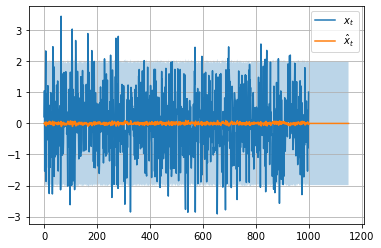

In [27]:
fig, ax = plt.subplots()
plt.plot(x, label=r'$x_t$')
preds_df['mean'].plot(ax=ax, label=r'$\hat{x}_t$')
ax.fill_between(preds_df.index, preds_df['mean_ci_lower'],
                preds_df['mean_ci_upper'], alpha=0.3)
plt.legend()